# OLG Homework

Natasha Watkins

In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
import time

### Exercise 2.1

In [2]:
β = 0.442
δ = 0.6415
σ = 3
A = 1
α = 0.35

nvec = np.array([1, 1, 0.2])

f_params = (nvec, A, α, δ)
bvec_guess = np.array([1.0, 2.0])

u = lambda c: (c**(1 - σ) - 1) / (1 - σ)   # CRRA utility
u_prime = lambda c: c**(-σ)                # First derivative of u

In [3]:
w = lambda α, A, L, K: (1 - α) * A * (K / L)**α
r = lambda α, A, L, K, δ: α * A * (L / K)**(1 - α) - δ

In [4]:
def feasible(f_params, bvec_guess):
    
    nvec, A, α, δ = f_params  # Unpack parameters
    K = np.sum(bvec_guess)    # Total capital
    L = np.sum(nvec)          # Total labour
    
    b_cnstr, c_cnstr = np.empty(2, dtype=bool), np.empty(3, dtype=bool)
    K_cnstr = np.ones(1, dtype=bool)  # Default to False
    
    K_cnstr[0] = K <= 0
    
    w_t = w(α, A, L, K)     # Equilibrium wage rate
    r_t = r(α, A, L, K, δ)  # Equilibrium interest rate
            
    c1 = nvec[0] * w_t - bvec_guess[0]
    c2 = nvec[1] * w_t + (1 + r_t) * bvec_guess[0] - bvec_guess[1]
    c3 = nvec[2] * w_t + (1 + r_t) * bvec_guess[1]
    
    c = np.array([c1, c2, c3])  # Consumption path
    c_cnstr = c <= 0
    
    if c_cnstr[0]:              # If c1 <= 0
        b_cnstr[0] = True
    elif c_cnstr[1]:            # If c2 <= 0, set both elements to true
        b_cnstr[:] = True
    elif c_cnstr[2]:            # If c3 <= 0
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

**Question a)**

In [5]:
bvec_guess = np.array([1.0, 1.2])
feasible(f_params, bvec_guess)

(array([ True,  True]), array([ True, False, False]), array([False]))

The time-1 budget constraint is violated.

**Question b)**

In [6]:
bvec_guess = np.array([0.06, -0.001])
feasible(f_params, bvec_guess)

(array([ True,  True]), array([False, False, False]), array([False]))

No budget constraints are violated.

**Question c)**

In [7]:
bvec_guess = np.array([0.1, 0.1])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), array([False]))

No budget constraints are violated.

### Exercise 2.2

**Part a)**

In [8]:
SS_tol = 1e-5
params = (β, σ, nvec, A, α, δ, SS_tol)

def get_SS(params, bvec_guess, SS_graphs=False):
    
    start_time = time.clock()  # Start timing
    
    β, σ, nvec, A, α, δ, SS_tol = params
    n1, n2, n3 = nvec  # Labour supply in each period
    L = np.sum(nvec)   # Total labour supply
    
    def equations(bvec):
        b2, b3 = bvec
        K = np.sum(bvec)        # Total capital
        w_t = w(α, A, L, K)     # Equilibrium wage rate
        r_t = r(α, A, L, K, δ)  # Equilibrium interest rate
        eq1 = u_prime(n1 * w_t - b2) - β * (1 + r_t) * u_prime(n2 * w_t + (1 + r_t) * b2 - b3)
        eq2 = u_prime(n2 * w_t + (1 + r_t) * b2 - b3) - β * (1 + r_t) * u_prime((1 + r_t) * b3 + n3 * w_t)
        return eq1, eq2
    
    b_ss = root(equations, x0=bvec_guess, tol=SS_tol).x  # Solve for steady state b
    K_ss = np.sum(b_ss)         # Steady state capital
    w_ss = w(α, A, L, K_ss)     # Steady state wage
    r_ss = r(α, A, L, K_ss, δ)  # Steady state interest rate
    
    # Back out consumption path
    c_1 = n1 * w_ss - b_ss[0]
    c_2 = n2 * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c_3 = n3 * w_ss + (1 + r_ss) * b_ss[1]
    c_ss = np.array([c_1, c_2, c_3])  # Steady state consumption path
    C_ss = c_ss.sum()                 # Total steady state consumption
    
    # Back out steady state investment path
    I_ss = (b_ss[1] - (1 - δ) * b_ss[0]).sum()
    
    Y_ss = C_ss + I_ss  # Total output
    
    # Euler errors
    EulErr_ss = β * (1 + r_ss) * u_prime(c_ss[1:]) - u_prime(c_ss[:-1])

    # Resource contraint error
    RCerr_ss = Y_ss - C_ss - δ * K_ss

    ss_time = time.clock() - start_time  # Stop timing
    
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
                 'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                 'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                 'ss_time': ss_time}
    
    if SS_graphs:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].bar(range(2, 4), b_ss)
        axes[0].set(xticks=([2, 3]), xlabel='State', title='Steady state $b_t$')
        axes[1].bar(range(1, 4), c_ss)
        axes[1].set(xticks=([1, 2, 3]), xlabel='State', title='Steady state $c_t$')
        plt.tight_layout()
        plt.show()
    
    return ss_output

In [9]:
ss = get_SS(params, np.array([0.1, 0.1]))
ss

{'C_ss': 0.6329006782167177,
 'EulErr_ss': array([ 4.50781670e-06, -8.92472291e-06]),
 'K_ss': 0.0777236279220895,
 'RCerr_ss': 0.0016278487132806718,
 'Y_ss': 0.6843882342420188,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'r_ss': 2.433062283358659,
 'ss_time': 0.0006929999999996106,
 'w_ss': 0.20172465936076353}

**Part b)**

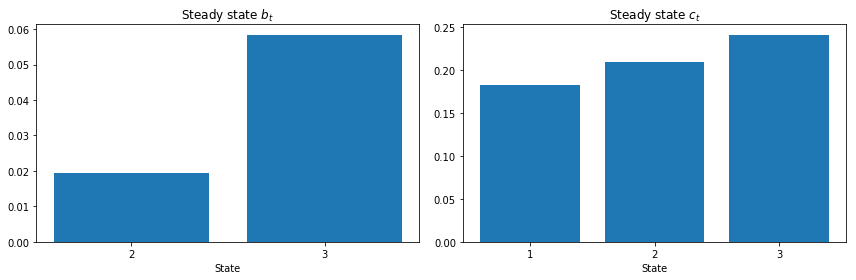

In [10]:
ss = get_SS(params, np.array([0.1, 0.1]), SS_graphs=True)

**Part c)**

In [11]:
β = 0.55
params = (β, σ, nvec, A, α, δ, SS_tol)
get_SS(params, np.array([0.1, 0.1]))

{'C_ss': 0.691284290244305,
 'EulErr_ss': array([6.82726977e-08, 2.51137209e-08]),
 'K_ss': 0.10504237016721853,
 'RCerr_ss': -0.0006206546125954587,
 'Y_ss': 0.7580483160939803,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'r_ss': 1.8863765066381661,
 'ss_time': 0.00043700000000024275,
 'w_ss': 0.2241521958905792}

A higher $\beta$ increases consumption and investment in every period. The equilibrium wage rate is higher, while the interest rate is lower.

Increasing $\beta$ results in an agent being more likely to spend today, as future consumption is discounted at a higher rate. As consumption is higher, total output is higher, allowing agents to save more.